<a href="https://colab.research.google.com/github/buzaev-fedor/my-project-from-ml-course/blob/master/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Предсказание цены автомобиля с помощью классических алгоритмов и различных бустов. Данные взяты с Kaggle https://www.kaggle.com/austinreese/craigslist-carstrucks-data

### Import libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory  


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
!pip install catboost
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
!pip install xgboost

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


     |████████████████████████████████| 64.8MB 66kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/vehicles.csv")

In [ ]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,vin,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7119256118,https://mohave.craigslist.org/ctd/d/lake-havas...,mohave county,https://mohave.craigslist.org,3495,2012.0,jeep,patriot,like new,4 cylinders,gas,NaN,clean,automatic,NaN,NaN,NaN,NaN,silver,https://images.craigslist.org/00B0B_k2AXIJ21ok...,"THIS 2012 JEEP PATRIOT IS A 4CYL. AC, STEREO, ...",NaN,az,34.4554,-114.2690
1,7120880186,https://oregoncoast.craigslist.org/cto/d/warre...,oregon coast,https://oregoncoast.craigslist.org,13750,2014.0,bmw,328i m-sport,good,NaN,gas,76237.0,clean,automatic,NaN,rwd,NaN,sedan,grey,https://images.craigslist.org/00U0U_3cLk0WGOJ8...,Selling my 2014 BMW 328i with the following be...,NaN,or,46.1837,-123.8240
2,7115048251,https://greenville.craigslist.org/cto/d/sparta...,greenville / upstate,https://greenville.craigslist.org,2300,2001.0,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/00k0k_t4WqYn5nDC...,"01 DODGE CARAVAN,3.3 ENGINE,AUT TRANS,199000 M...",NaN,sc,34.9352,-81.9654
3,7119250502,https://mohave.craigslist.org/cto/d/lake-havas...,mohave county,https://mohave.craigslist.org,9000,2004.0,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,1GCCS196448191644,rwd,mid-size,pickup,red,https://images.craigslist.org/00J0J_lJEzfeVLHI...,"2004 Chevy Colorado LS, ONLY 54000 ORIGINAL MI...",NaN,az,34.4783,-114.2710
4,7120433904,https://maine.craigslist.org/ctd/d/searsport-t...,maine,https://maine.craigslist.org,0,2021.0,NaN,Honda-Nissan-Kia-Ford-Hyundai-VW,NaN,NaN,other,NaN,clean,other,NaN,NaN,NaN,NaN,NaN,https://images.craigslist.org/01010_j0IW34mCsm...,CALL: 207.548.6500 TEXT: 207.407.5598 **WE FI...,NaN,me,44.4699,-68.8963


### Preprocessing

#### Look null values in dataset and delete unnecessary data

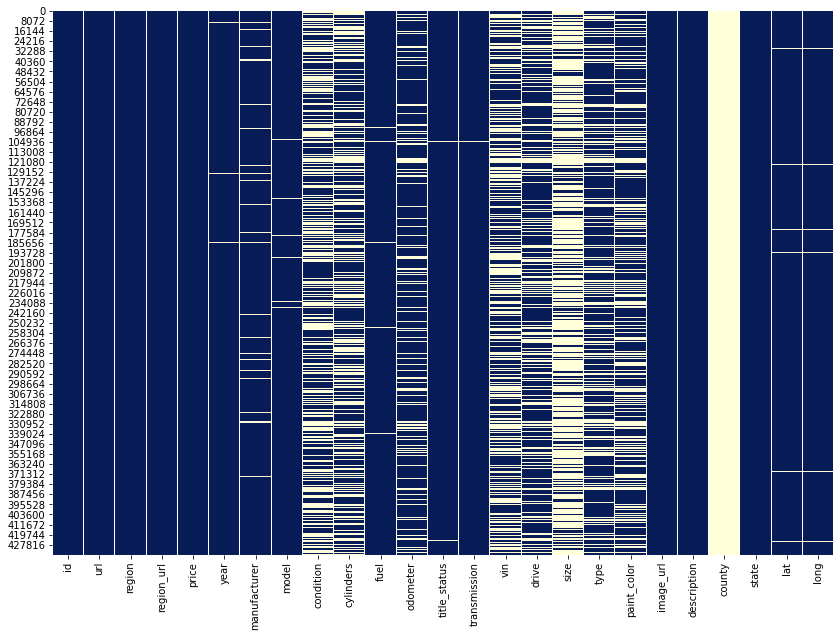

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

In [ ]:
del df['url']
del df['region_url']
del df['vin']
del df['title_status']
del df['size']
del df['image_url']
del df['county']
del df['id']
del df['state']
del df['long']
del df['lat']
del df['description']
del df['region']

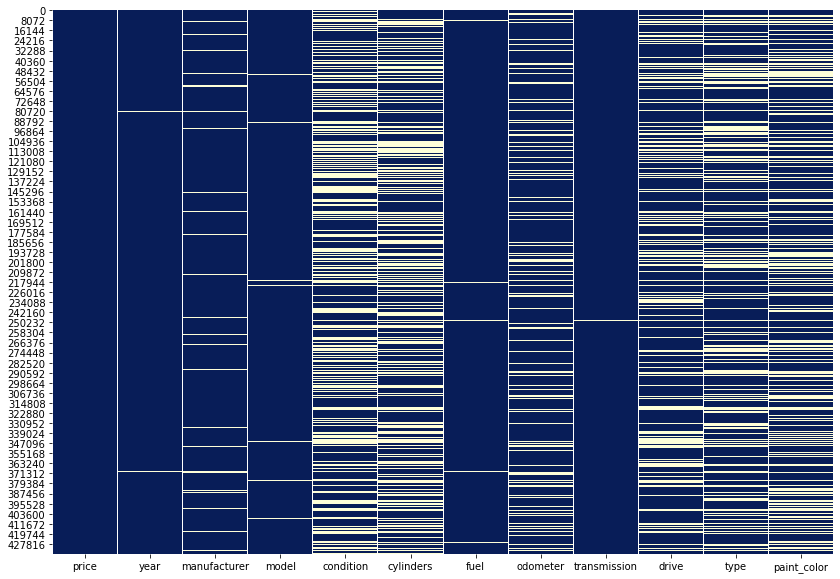

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

#### Delete anomaly values

In [ ]:
df = df.dropna()

In [ ]:
df.drop(df[df.price.values == 0].index, inplace = True)
df.drop(df[df.year.values > 2019].index, inplace = True)
df.drop(df[df.odometer.values > 55000].index, inplace = True)
df.price.dropna(axis = 0, inplace = True)
df.drop(df[df.price.values < 700].index, inplace = True)

In [ ]:
df['year'] = (df['year']-1900).astype(int)
df['odometer'] = df['odometer'].astype(int)

In [ ]:
df = df[df['price'] > 1000]
df = df[df['price'] < 40000]
# Rounded ['odometer'] to 5000
df['odometer'] = df['odometer'] // 5000
df = df[df['year'] > 110]

#### Fill NaN values

In [ ]:
# df = df.fillna(0)

In [ ]:
# df.head()

#### Lower the text

In [ ]:
import string
# realization preprocessing
def preprocess(doc):
    try:
        # lower the text
        doc = doc.lower()
        # remove punctuation, spaces, etc.
        for p in string.punctuation + string.whitespace:
            doc = doc.replace(p, ' ')
        # remove extra spaces, merge back
        doc = doc.strip()
        doc = ' '.join([w for w in doc.split(' ') if w != ''])
    except:
        pass
    return doc

In [ ]:
for colname in df.select_dtypes(include = np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
19,24930,117,subaru,outback 2 5i limited,excellent,4 cylinders,gas,6,automatic,4wd,suv,grey
39,10200,113,nissan,juke nismo,excellent,4 cylinders,gas,9,automatic,4wd,suv,silver
54,12900,112,cadillac,cts luxury sedan,good,6 cylinders,gas,9,automatic,fwd,sedan,white
77,16000,114,audi,a5 premium plus coupe 2dr,good,4 cylinders,gas,9,automatic,fwd,coupe,grey
81,10700,117,ford,escape se,like new,4 cylinders,gas,7,automatic,fwd,suv,blue


#### Clip the dataset

In [ ]:
# df = df[:100000]

#### Label encoding

In [ ]:
columns = ['manufacturer', 'fuel', 'type', 'transmission', 'drive', 'paint_color', 'model', 'cylinders', 'condition']

In [ ]:
le = LabelEncoder()
for col in columns:
    if col in df.columns:
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [ ]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [ ]:
df.corr()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
price,1.000000,0.263653,-0.070108,0.125352,0.114512,0.636714,-0.018240,-0.121092,0.175484,-0.235065,0.043574,0.044163
year,0.263653,1.000000,0.043999,0.050646,0.111834,-0.085535,0.104240,-0.280660,-0.005754,-0.115878,0.179907,0.043896
manufacturer,-0.070108,0.043999,1.000000,0.041896,-0.007998,-0.194453,-0.111766,-0.035253,-0.001477,-0.154102,0.116305,-0.019640
model,0.125352,0.050646,0.041896,1.000000,-0.000057,0.088752,0.028124,0.001526,-0.041028,-0.147190,0.187014,0.007549
condition,0.114512,0.111834,-0.007998,-0.000057,1.000000,0.099632,0.056111,-0.134720,0.163111,0.041362,-0.094553,0.001662
cylinders,0.636714,-0.085535,-0.194453,0.088752,0.099632,1.000000,0.041656,0.008721,0.251790,-0.036678,-0.077833,0.046469
fuel,-0.018240,0.104240,-0.111766,0.028124,0.056111,0.041656,1.000000,-0.030483,0.104984,0.006966,-0.093700,-0.013519
odometer,-0.121092,-0.280660,-0.035253,0.001526,-0.134720,0.008721,-0.030483,1.000000,-0.016024,-0.036004,0.024536,-0.011077
transmission,0.175484,-0.005754,-0.001477,-0.041028,0.163111,0.251790,0.104984,-0.016024,1.000000,0.073161,-0.303199,-0.012599
drive,-0.235065,-0.115878,-0.154102,-0.147190,0.041362,-0.036678,0.006966,-0.036004,0.073161,1.000000,-0.375705,0.071920


### Train-test split

In [ ]:
# sample data for best results
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
y = df['price']
y

0        1.108202
1        0.224417
2       -0.789859
3       -0.903743
4        2.186064
           ...   
19612    0.865013
19613    0.757891
19614   -0.265164
19615    0.045288
19616    1.819975
Name: price, Length: 19617, dtype: float64

In [ ]:
del df['price']

In [ ]:
X_classic = df

In [ ]:
X_classic

,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color
0,0.430760,-0.502679,1.018902,1.251818,1.331545,0.035265,-1.241129,-0.435054,-1.028270,0.951872,1.058096
1,0.430760,-0.934831,-1.661962,1.251818,0.535394,0.035265,0.091195,-0.435054,1.631658,0.213493,-1.427405
2,0.430760,0.145549,1.148391,0.477103,0.535394,0.035265,-0.574967,-0.435054,0.301694,1.321062,0.809546
3,1.396721,1.009852,1.585142,0.477103,-1.056908,0.035265,-0.908048,-0.435054,0.301694,0.213493,0.560996
4,-0.535200,0.577700,0.919041,-1.072327,1.331545,0.035265,0.091195,-0.435054,-1.028270,0.213493,-1.427405
...,...,...,...,...,...,...,...,...,...,...,...
19612,-0.052220,1.225928,-1.832054,0.477103,1.331545,0.035265,0.424276,-0.435054,-1.028270,0.951872,-0.184655
19613,0.913741,-0.610717,1.452361,0.477103,0.535394,0.035265,0.757358,-0.435054,1.631658,1.321062,1.058096
19614,-0.535200,0.361625,0.389014,-1.072327,0.535394,0.035265,0.091195,-0.435054,0.301694,0.213493,0.560996
19615,0.430760,-1.042869,1.479795,0.477103,0.535394,0.035265,0.424276,2.535002,0.301694,-0.524887,-1.178855


In [ ]:
X_train_classic, X_test_classic, y_train, y_test = train_test_split(X_classic, y, test_size=0.20)

In [ ]:
X_train_classic.shape, X_test_classic.shape

((15693, 11), (3924, 11))

### Classic algorithms

#### Linear regression

In [ ]:
%%time
reg = LinearRegression().fit(X_train_classic, y_train)

CPU times: user 12 ms, sys: 3.12 ms, total: 15.1 ms
Wall time: 30 ms


In [ ]:
predictions = reg.predict(X_test_classic)

In [ ]:
print(metrics.r2_score(y_test, predictions))

0.5524967310354306


In [ ]:
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.511970478621627
MSE: 0.450973115792428
RMSE: 0.6715453192394598


#### Ridge

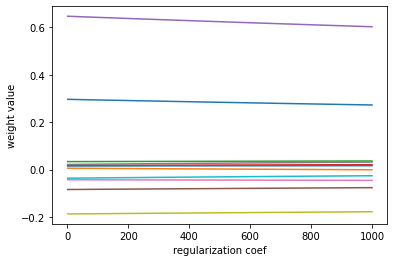

CPU times: user 584 ms, sys: 662 ms, total: 1.25 s
Wall time: 468 ms


In [ ]:
%%time
alphas = np.linspace(1, 1000, 100)

weights = np.empty((len(X_classic.columns), 0))
for alpha in alphas:
    ridge_regressor = Ridge(alpha)
    ridge_regressor.fit(X_train_classic, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))
plt.plot(alphas, weights.T)
plt.xlabel('regularization coef')
plt.ylabel('weight value')
plt.show()

In [ ]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train_classic, y_train)
predictions = ridge.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.5119745003914875
MSE: 0.4509722101302261
RMSE: 0.6715446449270712
R2:  0.5524976297293477


#### Lasso

In [ ]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train_classic, y_train)
predictions = lasso.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.8345531970319109
MSE: 1.008947503744109
RMSE: 1.0044637891651989
R2:  -0.001184528141470631


#### SVR

In [ ]:
%%time
grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

reg = SVR()
gs = GridSearchCV(reg, grid, verbose = 2, scoring = 'r2')

# Обучаем его
gs.fit(X_train_classic, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... kernel=linear, total=  19.6s
[CV] kernel=linear ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV] .................................... kernel=linear, total=  19.9s
[CV] kernel=linear ...................................................
[CV] .................................... kernel=linear, total=  19.9s
[CV] kernel=linear ...................................................
[CV] .................................... kernel=linear, total=  19.7s
[CV] kernel=linear ...................................................
[CV] .................................... kernel=linear, total=  19.5s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=  14.6s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=  15.0s
[CV] kernel=poly .....................................................
[CV] ...................................... kernel=poly, total=  14.1s
[CV] kernel=poly .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.1min finished


CPU times: user 5min 21s, sys: 387 ms, total: 5min 21s
Wall time: 5min 21s


In [ ]:
SVR = SVR()
SVR.fit(X_train_classic, y_train)
predictions = SVR.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.3824127136863532
MSE: 0.2851504691784176
RMSE: 0.533994821302995
R2:  0.7142372811259232


#### SGD

In [ ]:
sgd = SGDRegressor(alpha = 0.002004008016032064, penalty = 'l2')
sgd.fit(X_train_classic, y_train)
predictions = sgd.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.5133136544198059
MSE: 0.45116322039506257
RMSE: 0.6716868469719074
R2:  0.5523080891227643


#### Catboost regressor

In [ ]:
%%time
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=15000, 
                           task_type="GPU",
                           devices='0:1')
model.fit(X_train_classic,
          y_train,
          verbose=False)

predictions = model.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.3063559787155766
MSE: 0.1853059134161811
RMSE: 0.4304717335855876
R2:  0.8161198548022209
CPU times: user 2min 58s, sys: 51.4 s, total: 3min 50s
Wall time: 2min 47s


In [ ]:
# 10k = 0.8154211652300328

### Decision tree, random forest and different boost

#### Decision tree

In [ ]:
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train_classic, y_train)
predictions = decision_tree.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.292585651464591
MSE: 0.28127774479807305
RMSE: 0.5303562432913117
R2:  0.7208864433904398


#### Random forest

In [ ]:
rnd_forest_reg = RandomForestRegressor(max_depth = 14, min_samples_split = 2, n_estimators = 1000)
rnd_forest_reg.fit(X_train_classic, y_train)
predictions = rnd_forest_reg.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.27712979411229804
MSE: 0.1764980375179658
RMSE: 0.4201166951193035
R2:  0.8248599617377745


#### AdaBoost Regressor

In [ ]:
Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(X_train_classic, y_train)
predictions = Ada_Boost.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

MAE: 0.5410324024338522
MSE: 0.46158876289690104
RMSE: 0.6794032402755384
R2:  0.5419627621244933


#### XGBoost

In [ ]:
xbg_reg = xgb.XGBRegressor(max_depth = 7, learning_rate = 0.1, n_estimators = 130, reg_lambda = 0.5)
xbg_reg.fit(X_train_classic, y_train)
predictions = xbg_reg.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))

[14:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.28881971371529097
MSE: 0.1713896827322906
RMSE: 0.41399237037932307
R2:  0.8299290121657663


#### Catboost

In [ ]:
%%time
from catboost import CatBoostRegressor

grid = {'iterations': [i for i in range(15000, 16000, 2)],
        'learning_rate': np.linspace(0.01, 0.1, 10),
        'depth': [i for i in range(9, 12, 5)],
        'reg_lambda': [0.5]}

reg = CatBoostRegressor()
gs = GridSearchCV(reg, grid, verbose = 2, scoring = 'r2')

# Обучаем его
gs.fit(X_train_classic, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
[CV] depth=9, iterations=15000, learning_rate=0.01, reg_lambda=0.5 ...
0:	learn: 0.9873229	total: 72.6ms	remaining: 18m 8s
1:	learn: 0.9811211	total: 97.2ms	remaining: 12m 8s
2:	learn: 0.9752283	total: 120ms	remaining: 9m 59s
3:	learn: 0.9693173	total: 137ms	remaining: 8m 31s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Выходные данные были обрезаны до нескольких последних строк (5000).
10014:	learn: 0.1747063	total: 3m 32s	remaining: 1m 45s
10015:	learn: 0.1746985	total: 3m 32s	remaining: 1m 45s
10016:	learn: 0.1746873	total: 3m 32s	remaining: 1m 45s
10017:	learn: 0.1746743	total: 3m 32s	remaining: 1m 45s
10018:	learn: 0.1746683	total: 3m 32s	remaining: 1m 45s
10019:	learn: 0.1746587	total: 3m 32s	remaining: 1m 45s
10020:	learn: 0.1746479	total: 3m 32s	remaining: 1m 45s
10021:	learn: 0.1746191	total: 3m 32s	remaining: 1m 45s
10022:	learn: 0.1746042	total: 3m 32s	remaining: 1m 45s
10023:	learn: 0.1745958	total: 3m 32s	remaining: 1m 45s
10024:	learn: 0.1745869	total: 3m 32s	remaining: 1m 45s
10025:	learn: 0.1745710	total: 3m 32s	remaining: 1m 45s
10026:	learn: 0.1745583	total: 3m 32s	remaining: 1m 45s
10027:	learn: 0.1745388	total: 3m 32s	remaining: 1m 45s
10028:	learn: 0.1745249	total: 3m 32s	remaining: 1m 45s
10029:	learn: 0.1745186	total: 3m 32s	remaining: 1m 45s
10030:	learn: 0.1745138	total: 3m 32

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s


Выходные данные были обрезаны до нескольких последних строк (5000).
1063:	learn: 0.3990017	total: 22.4s	remaining: 4m 52s
1064:	learn: 0.3989385	total: 22.4s	remaining: 4m 52s
1065:	learn: 0.3988454	total: 22.4s	remaining: 4m 52s
1066:	learn: 0.3987583	total: 22.4s	remaining: 4m 52s
1067:	learn: 0.3986317	total: 22.4s	remaining: 4m 52s
1068:	learn: 0.3985887	total: 22.4s	remaining: 4m 52s
1069:	learn: 0.3985287	total: 22.5s	remaining: 4m 52s
1070:	learn: 0.3984437	total: 22.5s	remaining: 4m 52s
1071:	learn: 0.3983836	total: 22.5s	remaining: 4m 52s
1072:	learn: 0.3982717	total: 22.5s	remaining: 4m 52s
1073:	learn: 0.3981841	total: 22.5s	remaining: 4m 52s
1074:	learn: 0.3981042	total: 22.6s	remaining: 4m 52s
1075:	learn: 0.3980191	total: 22.6s	remaining: 4m 52s
1076:	learn: 0.3979348	total: 22.6s	remaining: 4m 52s
1077:	learn: 0.3978280	total: 22.6s	remaining: 4m 52s
1078:	learn: 0.3977571	total: 22.6s	remaining: 4m 52s
1079:	learn: 0.3976864	total: 22.7s	remaining: 4m 51s
1080:	learn: 0

In [ ]:
model = CatBoostRegressor(iterations=15000, 
                           task_type="GPU",
                           devices='0:1')
model.fit(X_train_classic,
          y_train,
          verbose=False)

predictions = model.predict(X_test_classic)
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2: ', metrics.r2_score(y_test, predictions))